# Import

In [28]:
import numpy as np
from math import sqrt 
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)


2.9.1


## load dataset

In [2]:
dataset = pd.read_csv('eMalahleniIM.csv', sep =';', header=0, index_col=0)
values = dataset.values

## Plot pm2.5

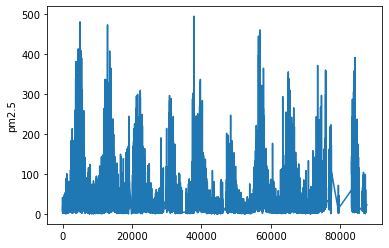

In [3]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [5]:
dataset.columns

Index(['pm2.5', 'pm10', 'so2', 'no2', 'no', 'nox', 'o3', 'co', 'ws', 'wd',
       'temp', 'relHum', 'pressure'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [6]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]], axis=1, inplace=True)
values = reframed.values

## View the data

In [7]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t)
1,0.018966,0.016509,0.017832,0.023121,0.007442,0.015058,0.380849,0.004532,0.487526,0.493486,0.546332,0.833146,0.549068,0.026136
2,0.026136,0.016882,0.069390,0.088378,0.006463,0.036362,0.334627,0.003827,0.455301,0.539821,0.503610,0.942542,0.561046,0.038245
3,0.038245,0.024513,0.104785,0.121924,0.008580,0.049843,0.225011,0.024270,0.373181,0.403761,0.495473,0.916471,0.562208,0.015315
4,0.015315,0.009721,0.035120,0.013445,0.005276,0.009682,0.431832,0.022155,0.505198,0.313120,0.492930,0.856865,0.545851,0.010145
5,0.010145,0.006823,0.022419,0.026773,0.006716,0.015604,0.408700,0.006143,0.279626,0.275397,0.513782,0.789183,0.537181,0.023049


## Create X and Y variables

In [8]:
values.shape

(87645, 14)

In [9]:
X = values[:,:-1]

In [10]:
Y = values[:,-1]

## Check the shapes

In [11]:
X.shape

(87645, 13)

In [12]:
Y.shape

(87645,)

## Reshaping

The format that Keras expects is [batches, timesteps, features]

In [13]:
X = X.reshape(X.shape[0],1,X.shape[1])

In [14]:
X.shape

(87645, 1, 13)

## Training, validation and testing split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [16]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (56092, 1, 13)
Y_train: (56092,)

X_val: (14024, 1, 13)
Y_val: (14024,)

X_test: (17529, 1, 13)
Y_test: (17529,)


## Define a model

In [17]:
model = Sequential()
model.add(LSTM(56, input_shape=(1, 13)))
model.add(Dense(56, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(56, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(56, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(56, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='adam')

## Print summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56)                15680     
                                                                 
 dense (Dense)               (None, 56)                3192      
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense_1 (Dense)             (None, 56)                3192      
                                                                 
 dropout_1 (Dropout)         (None, 56)                0         
                                                                 
 dense_2 (Dense)             (None, 56)                3192      
                                                                 
 dropout_2 (Dropout)         (None, 56)                0

## Training

In [19]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=16, verbose=1)

Epoch 1/30
3506/3506 [==============================] - 22s 5ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 2/30
3506/3506 [==============================] - 16s 5ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/30
3506/3506 [==============================] - 16s 5ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/30
3506/3506 [==============================] - 16s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/30
3506/3506 [==============================] - 16s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/30
3506/3506 [==============================] - 15s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/30
3506/3506 [==============================] - 16s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/30
3506/3506 [==============================] - 15s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/30
3506/3506 [==============================] - 16s 5ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/30
3506/3506 [==============================] - 16s 4ms/step - l

## Predict

In [20]:
prediction = model.predict(X_test)

548/548 [==============================] - 2s 3ms/step


In [21]:
def unscale(scaled_value):
    # if target variable is the first column, then, data_max_[0]
    unscaled_value = scaled_value * (scaler.data_max_[0] - scaler.data_min_[0]) + (scaler.data_min_[0])
    return unscaled_value

In [22]:
predictions = unscale(prediction)

In [23]:
Y_tests = unscale(Y_test)

In [24]:
mean_absolute_error(Y_tests, predictions)

7.533973

In [25]:
rmse = sqrt(mean_squared_error(Y_tests, predictions))
print(rmse)

16.14075545990355


In [26]:
print(r2_score(Y_tests, predictions))

0.719212871197292


In [ ]:
print('accuracy testing = {}'.format(np.sum(prediction==Y_test)))

## Compare prediction and testing data

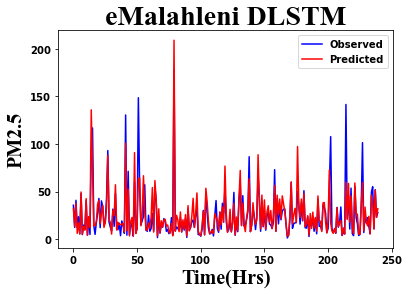

In [30]:
rcParams['font.weight'] = 'bold'
plt.plot(Y_tests[0:240], color='blue', label = 'Observed')
plt.plot(predictions[0:240], color='red', label = 'Predicted')
plt.ylabel('PM2.5', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('eMalahleni DLSTM', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()

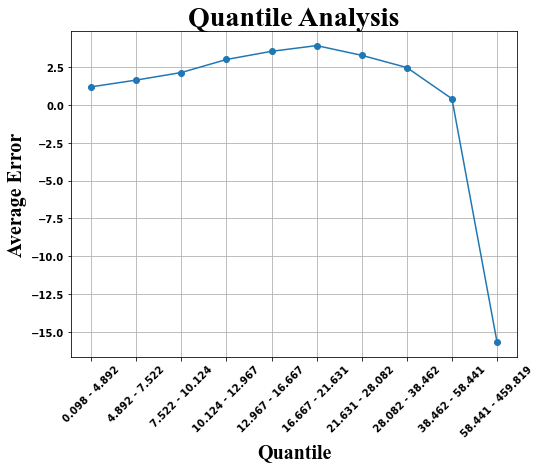

In [31]:
errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Round the bin edges for better readability
rounded_bins = np.round(bins, decimals=3)

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20, fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20, fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28, fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [f'{rounded_bins[i]:.3f} - {rounded_bins[i+1]:.3f}' for i in range(len(rounded_bins) - 1)], rotation=45)
plt.grid(True)
plt.show()

In [ ]:
mean_absolute_error(Y_test[1:6], prediction[1:6])

In [ ]:
mean_absolute_error(Y_test[1:12], prediction[1:12])

In [ ]:
mean_absolute_error(Y_test[1:18], prediction[1:18])

In [ ]:
mean_absolute_error(Y_test[1:24], prediction[1:24])

In [ ]:
mean_absolute_error(Y_test[1:36], prediction[1:36])

In [ ]:
mean_absolute_error(Y_test[1:48], prediction[1:48])

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:6], prediction[1:6]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:12], prediction[1:12]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:18], prediction[1:18]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:24], prediction[1:24]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:36], prediction[1:36]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:48], prediction[1:48]))
print(rmse)